In [116]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

L = 1
N = 128
T = 0.01
K = 20

tau = T / K
h = L / N

def u(X, Y, Z, t):
    return np.sin(2 * np.pi / L * X) * np.sin(np.pi / L * Y) * np.sin(np.pi / L * Z) * np.cos(t * 0.5 * np.sqrt(6 / (L * L)) + 2 * np.pi)

In [117]:
def compute_anal_t(t):
    anal_matrix_t = np.zeros((N + 1, N + 1, N + 1))
    for x in range(N + 1):
        for y in range(N + 1):
            for z in range(N + 1):
                anal_matrix_t[x, y, z] = u(x * h, y * h, z * h, t * tau)
    return anal_matrix_t


def compute_anal_matrix():
    anal_matrix = process_map(compute_anal_t, list(range(K+1)), max_workers=4, chunksize=1)
    return np.stack(anal_matrix)

anal_matrix = compute_anal_matrix()

100%|██████████| 21/21 [00:57<00:00,  2.72s/it]


In [118]:
def read_t_matrix(t):
    with open(f"matrix/{t}.txt") as file:
        shape_line = file.readline().split(" ")
        shape_line = list(map(int, shape_line[1::2]))
        t_mat = file.readline().split(",")
        new_t_mat = []
        for num in t_mat:
            num = num.strip()
            if len(num) == 0:
                continue
            
            new_t_mat.append(
                float(num)
            )
            
        new_t_mat = np.array(new_t_mat).reshape((129, 129, 129))
        return new_t_mat
    
    
def compute_matrix():
    matrix = np.zeros((K + 1, N + 1, N + 1, N + 1))
    for t in tqdm(range(K + 1)):
        matrix[t] = read_t_matrix(t)
    return matrix


matrix = compute_matrix()

100%|██████████| 21/21 [00:16<00:00,  1.27it/s]


In [120]:
def downsample_matrix(matrix, factor):
    """ Уменьшение размера матрицы с заданным коэффициентом. """
    return matrix[:, ::factor, ::factor, ::factor]

def animate_matrix(matrix):
    """ Создание анимации для 4D матрицы. """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    min_value = np.min(matrix)
    max_value = np.max(matrix)

    norm = Normalize(vmin=min_value, vmax=max_value)  # Использование реальных минимального и максимального значений
    mappable = ScalarMappable(norm=norm, cmap='viridis')

    # Добавление цветовой шкалы к фигуре
    fig.colorbar(mappable, ax=ax, orientation='vertical')

    def update(frame):
        ax.clear()
        ax.set_title(f"Time = {frame}")
        # Визуализация только пространственных компонентов
        x, y, z = np.indices(matrix[frame].shape)
        ax.scatter(x.flatten(), y.flatten(), z.flatten(), c=matrix[frame].flatten(), cmap='viridis')

    ani = FuncAnimation(fig, update, frames=matrix.shape[0], interval=250)
    return ani


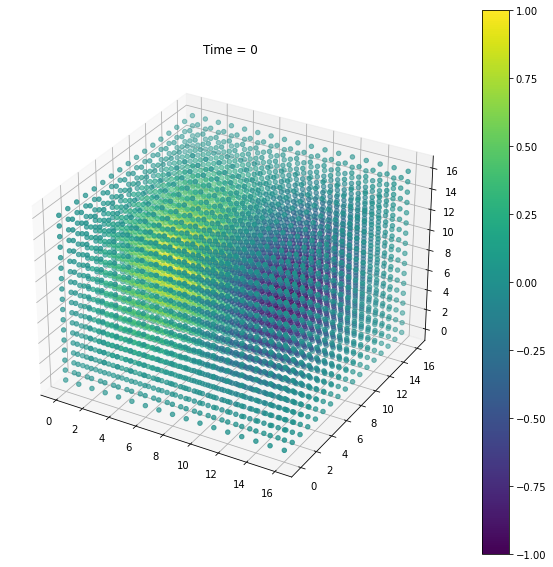

In [125]:
downsampled_matrix = downsample_matrix(matrix, factor=8)

# Анимация уменьшенной матрицы
ani = animate_matrix(downsampled_matrix)

In [126]:
ani.save("computed.mp4")

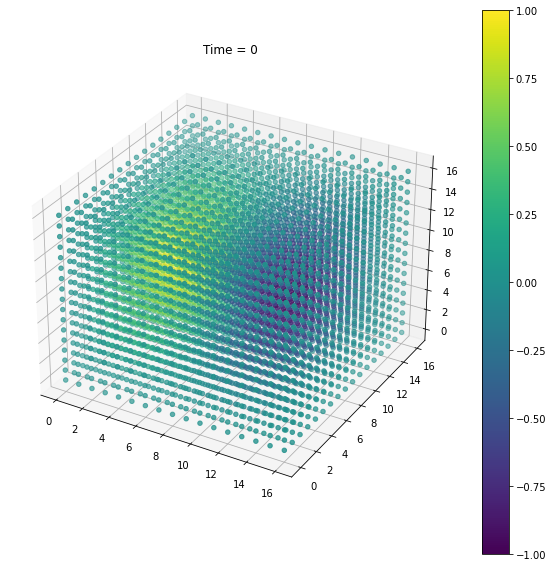

In [127]:
downsampled_matrix = downsample_matrix(anal_matrix, factor=8)

# Анимация уменьшенной матрицы
ani = animate_matrix(downsampled_matrix)

In [128]:
ani.save("analytical.mp4")

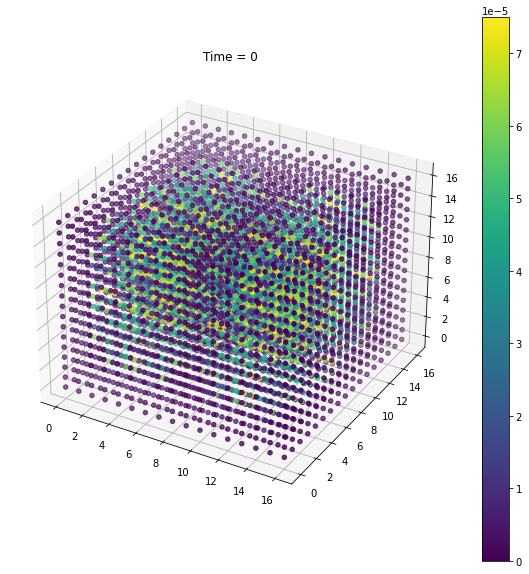

In [129]:
downsampled_matrix = downsample_matrix(np.abs(matrix - anal_matrix), factor=8)

# Анимация уменьшенной матрицы
ani = animate_matrix(downsampled_matrix)

In [130]:
ani.save("error.mp4")